In [2]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [3]:
data = np.load('flatland_train.npz')
X = data['X']
y = data['y']
y[y != 0] -= 2    # Correct labels so that triangle is mapped to class 1
X = X.reshape(X.shape[0], 50, 50, 1) / 255

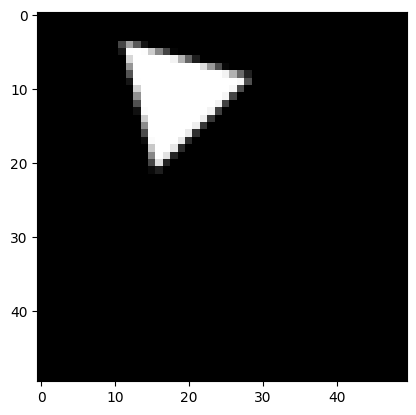

In [4]:
plt.imshow(X[5], cmap = 'gray')

In [5]:
X.shape

(10000, 50, 50, 1)

In [6]:
Counter(y)

Counter({2.0: 1868, 4.0: 1761, 3.0: 2137, 1.0: 2853, 0.0: 1381})

In [7]:
#X_train_aug = np.concatenate([X_train, X_train[..., ::-1]])
#y_train_aug = np.concatenate([y_train, y_train])

In [ ]:
inp = keras.layers.Input(shape = (50, 50, 1));
out = keras.layers.RandomFlip("horizontal_and_vertical")(inp);
#out = keras.layers.RandomRotation(0.2)(out);
#out = keras.layers.RandomZoom(0.2, 0.2)(out);
out = keras.layers.Conv2D(8, kernel_size=(3, 3), activation='relu', input_shape=[50, 50])(out);
out = keras.layers.MaxPooling2D(pool_size=(2, 2))(out);
out = keras.layers.Conv2D(8, kernel_size=(3, 3), activation='relu')(out);
out = keras.layers.MaxPooling2D(pool_size=(2, 2))(out);
out = keras.layers.Conv2D(16, kernel_size=(3, 3), activation='relu')(out);
out = keras.layers.MaxPooling2D(pool_size=(2, 2))(out);
out = keras.layers.Flatten()(out);
out = keras.layers.Dense(2000, activation = 'relu')(out);
out = keras.layers.Dropout(0.6)(out);
out = keras.layers.Dense(1000, activation = 'relu')(out);
out = keras.layers.Dropout(0.6)(out);
out = keras.layers.Dense(500, activation = 'relu')(out);
out = keras.layers.Dropout(0.6)(out);
out = keras.layers.Dense(200, activation = 'relu')(out);
out = keras.layers.Dropout(0.6)(out);
out = keras.layers.Dense(5, activation = 'softmax')(out);

model = keras.models.Model(inputs = inp, outputs = out);
model.compile(optimizer = keras.optimizers.Adam(learning_rate = 3e-4), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy']);
model.summary();

hist = model.fit(X, y, validation_split = 0.2, epochs = 25)

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 50, 50, 1)]       0         
                                                                 
 random_flip_8 (RandomFlip)  (None, 50, 50, 1)         0         
                                                                 
 conv2d_24 (Conv2D)          (None, 48, 48, 8)         80        
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 24, 24, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 22, 22, 8)         584       
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 11, 11, 8)        0         
 g2D)                                                      

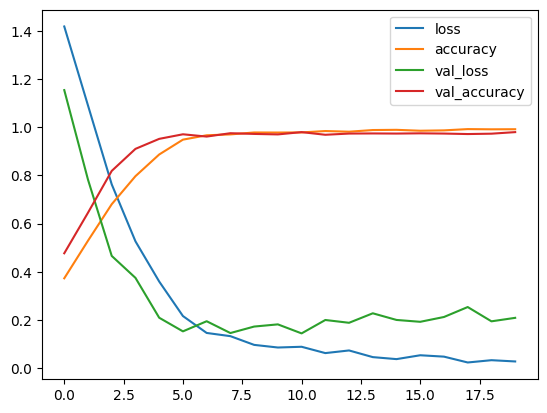

In [19]:
pd.DataFrame(hist.history).plot()
model.save('model.h5')